In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
import os

env_path = '../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")

In [2]:
pd.set_option('display.max_rows', 20)  
pd.set_option('display.max_columns', 20)  

In [3]:
project = hopsworks.login(project='AMomozZz', api_key_value=HOPSWORKS_API_KEY)

2024-12-30 18:39:48,751 INFO: Initializing external client
2024-12-30 18:39:48,752 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-30 18:39:50,013 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163416


In [4]:
# Retrieve feature groups
fs = project.get_feature_store()

gold_fg = fs.get_feature_group(
    name='gold_feature_group',
    version=1,
)
exchange_fg = fs.get_feature_group(
    name='exchange_feature_group',
    version=1,
)

In [5]:
gold_fg.select_all().read().sort_values(by=['date'], ascending=True).tail(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


,date,close_price
2935,2024-12-13 00:00:00+00:00,2656.000000
5357,2024-12-16 00:00:00+00:00,2651.399902
3292,2024-12-17 00:00:00+00:00,2644.399902
2607,2024-12-18 00:00:00+00:00,2636.500000
5078,2024-12-19 00:00:00+00:00,2592.199951
5611,2024-12-20 00:00:00+00:00,2628.699951
1922,2024-12-23 00:00:00+00:00,2612.300049
1809,2024-12-24 00:00:00+00:00,2620.000000
6102,2024-12-26 00:00:00+00:00,2638.800049
6103,2024-12-27 00:00:00+00:00,2636.500000


In [6]:
exchange_fg.select_all().read().sort_values(by=['date'], ascending=True).tail(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.94s) 


,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,...,close_price_1,close_price_2,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10
5183,2024-12-19 00:00:00+00:00,1.599900,1.881500,1.436300,0.896490,24.172000,7.177800,0.962000,0.793120,7.771500,...,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098
5730,2024-12-20 00:00:00+00:00,1.604800,1.882400,1.438500,0.894800,24.178000,7.181300,0.962460,0.798510,7.772400,...,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098
1975,2024-12-23 00:00:00+00:00,1.603700,1.881800,1.441200,0.898300,24.213000,7.176900,0.962190,0.798570,7.770300,...,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902
1862,2024-12-24 00:00:00+00:00,1.604700,1.881500,1.441800,0.900240,24.180000,7.177300,0.962000,0.796580,7.767500,...,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098
2423,2024-12-27 00:00:00+00:00,1.607800,1.874300,1.437700,0.900430,24.150000,7.149200,0.958310,0.796340,7.761400,...,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000
6230,2024-12-30 00:00:00+00:00,1.541141,1.838320,1.379623,0.897305,24.417318,6.989988,0.950156,0.789757,7.770858,...,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902
6231,2024-12-31 00:00:00+00:00,1.537346,1.851404,1.426810,0.867157,24.537416,7.081013,0.952036,0.792289,7.775136,...,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902
6229,2025-01-01 00:00:00+00:00,1.550713,1.845641,1.381803,0.879927,23.194738,6.919368,0.938662,0.788186,7.767988,...,0.000000,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000
6228,2025-01-02 00:00:00+00:00,1.608766,1.874190,1.411317,0.876733,24.185942,7.124239,0.946272,0.787828,7.776083,...,0.000000,0.000000,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951
6232,2025-01-03 00:00:00+00:00,1.560774,1.871500,1.362973,0.883546,24.057713,6.962848,0.939616,0.792183,7.770098,...,0.000000,0.000000,0.000000,0.000000,2636.500000,2638.800049,0.000000,2620.000000,2612.300049,2628.699951


## Prepare gold price prediction training data

In [8]:
# Select features for training data.
selected_features = gold_fg.select(['close_price']).join(exchange_fg.select_all(), on=['date'], join_type="inner")
# selected_features.show(10)
# selected_features_cleaned = selected_features.read().dropna(subset=['date'])
selected_features.read().sort_values(by=['date'], ascending=True).tail(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.67s) 


,close_price,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,...,close_price_1,close_price_2,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10
4579,2687.500000,2024-12-12 00:00:00+00:00,1.5645,1.8643,1.4169,0.88829,23.892,7.1092,0.95320,0.78570,...,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2653.800049,2644.699951,2634.899902,2657.000000,0.000000
6047,2656.000000,2024-12-13 00:00:00+00:00,1.5676,1.8595,1.4218,0.89228,23.787,7.0898,0.95075,0.78953,...,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2653.800049,2644.699951,2634.899902,2657.000000
2331,2651.399902,2024-12-16 00:00:00+00:00,1.5727,1.8630,1.4249,0.89274,23.848,7.1050,0.95256,0.79010,...,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2653.800049,2644.699951,2634.899902
1919,2644.399902,2024-12-17 00:00:00+00:00,1.5764,1.8632,1.4285,0.89673,23.877,7.1058,0.95265,0.78735,...,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2653.800049,2644.699951
5330,2636.500000,2024-12-18 00:00:00+00:00,1.5817,1.8634,1.4312,0.89386,23.940,7.1080,0.95274,0.78620,...,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2653.800049
3813,2592.199951,2024-12-19 00:00:00+00:00,1.5999,1.8815,1.4363,0.89649,24.172,7.1778,0.96200,0.79312,...,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098
753,2628.699951,2024-12-20 00:00:00+00:00,1.6048,1.8824,1.4385,0.89480,24.178,7.1813,0.96246,0.79851,...,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098
3432,2612.300049,2024-12-23 00:00:00+00:00,1.6037,1.8818,1.4412,0.89830,24.213,7.1769,0.96219,0.79857,...,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902
380,2620.000000,2024-12-24 00:00:00+00:00,1.6047,1.8815,1.4418,0.90024,24.180,7.1773,0.96200,0.79658,...,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098
4948,2636.500000,2024-12-27 00:00:00+00:00,1.6078,1.8743,1.4377,0.90043,24.150,7.1492,0.95831,0.79634,...,2638.800049,0.000000,2620.000000,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000


In [9]:
feature_view = fs.get_or_create_feature_view(
    name='exchange_feature_for_predict_gold_prices_view',
    description="exchange rate and few days ago close prices as the target",
    version=1,
    labels=['close_price'],
    query=selected_features,
)

In [10]:
start_date_test_data = "2024-12-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [11]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start,
)
display(X_train, X_test)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.02s) 


,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,...,close_price_1,close_price_2,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10
0,2000-09-05 00:00:00+00:00,1.7487,2.1910,1.4752,1.74320,39.746,8.3951,1.12540,0.68917,7.7963,...,0.000000,277.000000,278.299988,273.899994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2000-10-12 00:00:00+00:00,1.8839,2.2599,1.5057,1.74780,40.944,8.6117,1.15630,0.68467,7.7968,...,270.500000,272.399994,270.100006,269.299988,270.600006,270.299988,271.600006,273.100006,273.600006,275.600006
2,2000-11-10 00:00:00+00:00,1.9015,2.2443,1.5489,1.75640,40.029,8.5962,1.15300,0.69860,7.7990,...,265.799988,265.000000,264.299988,264.500000,264.600006,264.399994,263.899994,264.899994,264.299988,264.399994
3,2001-01-04 00:00:00+00:00,1.7715,2.0677,1.4951,1.60890,37.175,7.8900,1.05730,0.66885,7.7997,...,268.000000,268.399994,0.000000,272.000000,271.700012,275.200012,274.100006,0.000000,273.700012,273.700012
4,2001-02-14 00:00:00+00:00,1.8878,2.1291,1.5220,1.67300,37.571,8.1300,1.08960,0.68708,7.7997,...,260.299988,260.700012,259.899994,260.100006,262.799988,263.299988,265.200012,267.100006,268.500000,265.600006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6042,2024-10-21 00:00:00+00:00,1.4954,1.8021,1.3819,0.86428,23.282,6.8725,0.92140,0.76767,7.7721,...,2713.699951,2691.000000,2674.000000,2661.399902,2647.800049,2657.600098,2620.600098,2606.000000,2615.000000,2644.800049
6043,2024-11-08 00:00:00+00:00,1.5094,1.8156,1.3909,0.87198,23.401,6.9229,0.92833,0.77226,7.7743,...,2698.399902,2667.600098,2740.300049,2736.100098,2738.600098,2738.300049,2788.500000,2768.399902,2742.899902,2740.899902
6044,2024-11-13 00:00:00+00:00,1.5334,1.8401,1.3962,0.88240,23.798,7.0183,0.94082,0.78477,7.7789,...,2600.000000,2611.199951,2687.500000,2698.399902,2667.600098,2740.300049,2736.100098,2738.600098,2738.300049,2788.500000
6045,2024-11-15 00:00:00+00:00,1.5445,1.8481,1.4042,0.88718,23.893,7.0481,0.94491,0.78858,7.7847,...,2568.199951,2580.800049,2600.000000,2611.199951,2687.500000,2698.399902,2667.600098,2740.300049,2736.100098,2738.600098


,date,aud,bgn,cad,chf,czk,dkk,eur,gbp,hkd,...,close_price_1,close_price_2,close_price_3,close_price_4,close_price_5,close_price_6,close_price_7,close_price_8,close_price_9,close_price_10
378,2024-12-02 00:00:00+00:00,1.5429,1.8614,1.4036,0.88665,24.047,7.0984,0.95175,0.78898,7.7808,...,2657.000000,0.000000,2639.899902,2620.300049,2616.800049,2709.899902,2672.100098,2648.199951,2627.100098,2610.600098
379,2024-12-06 00:00:00+00:00,1.5600,1.8484,1.4065,0.87742,23.731,7.0489,0.94509,0.78305,7.7794,...,2626.600098,2653.800049,2644.699951,2634.899902,2657.000000,0.000000,2639.899902,2620.300049,2616.800049,2709.899902
380,2024-12-24 00:00:00+00:00,1.6047,1.8815,1.4418,0.90024,24.180,7.1773,0.96200,0.79658,7.7675,...,2612.300049,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098
753,2024-12-20 00:00:00+00:00,1.6048,1.8824,1.4385,0.89480,24.178,7.1813,0.96246,0.79851,7.7724,...,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098
1543,2024-12-09 00:00:00+00:00,1.5500,1.8507,1.4117,0.87954,23.744,7.0570,0.94625,0.78354,7.7748,...,2638.600098,2626.600098,2653.800049,2644.699951,2634.899902,2657.000000,0.000000,2639.899902,2620.300049,2616.800049
1919,2024-12-17 00:00:00+00:00,1.5764,1.8632,1.4285,0.89673,23.877,7.1058,0.95265,0.78735,7.7709,...,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2653.800049,2644.699951
2331,2024-12-16 00:00:00+00:00,1.5727,1.8630,1.4249,0.89274,23.848,7.1050,0.95256,0.79010,7.7753,...,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902,2638.600098,2626.600098,2653.800049,2644.699951,2634.899902
2717,2024-12-03 00:00:00+00:00,1.5430,1.8605,1.4034,0.88556,23.995,7.0956,0.95129,0.79074,7.7833,...,2634.899902,2657.000000,0.000000,2639.899902,2620.300049,2616.800049,2709.899902,2672.100098,2648.199951,2627.100098
3066,2024-12-05 00:00:00+00:00,1.5538,1.8556,1.4050,0.88283,23.858,7.0758,0.94877,0.78558,7.7824,...,2653.800049,2644.699951,2634.899902,2657.000000,0.000000,2639.899902,2620.300049,2616.800049,2709.899902,2672.100098
3432,2024-12-23 00:00:00+00:00,1.6037,1.8818,1.4412,0.89830,24.213,7.1769,0.96219,0.79857,7.7703,...,2628.699951,2592.199951,2636.500000,2644.399902,2651.399902,2656.000000,2687.500000,2733.800049,2697.600098,2664.899902


In [12]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)
train_features = X_train.drop(['date'], axis=1)
test_features = X_test.drop(['date'], axis=1)

In [13]:
y_train

,close_price
0,275.799988
1,276.399994
2,264.500000
3,267.299988
4,259.399994
...,...
6042,2723.100098
6043,2687.500000
6044,2580.800049
6045,2565.699951


## Train model

In [91]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [92]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 1954.8419240580665
R squared: -0.9199567320928426


In [98]:
df = y_test
df['predicted_close_price'] = y_pred
df['date'] = pd.to_datetime(X_test['date']).dt.date.values
df = df.sort_values(by=['date'])
# df.head(5)

df

,close_price,predicted_close_price,date
378,2634.899902,2555.328125,2024-12-02
2717,2644.699951,2607.802979,2024-12-03
4947,2653.800049,2645.094238,2024-12-04
3066,2626.600098,2658.230225,2024-12-05
379,2638.600098,2631.130615,2024-12-06
1543,2664.899902,2644.387939,2024-12-09
4578,2697.600098,2681.975342,2024-12-10
3812,2733.800049,2669.331055,2024-12-11
4579,2687.500000,2600.140137,2024-12-12
6047,2656.000000,2674.015381,2024-12-13


## Model metrics

In [99]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "gold_price_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

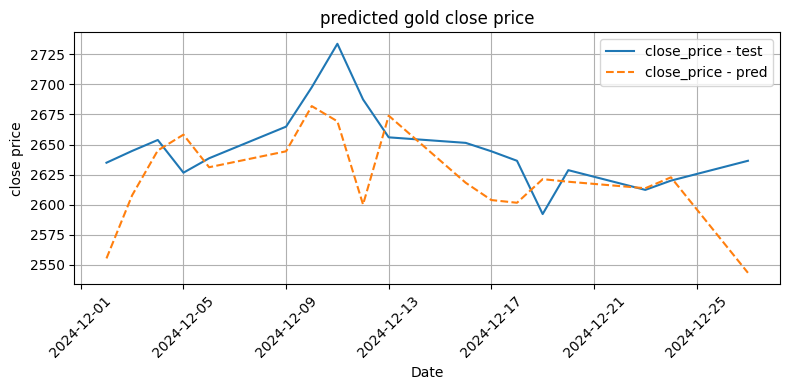

In [100]:
file_path = images_dir + "/gold_price_hindcast.png"
plt.figure(figsize=(8, 4))
plt.plot(df["date"], df["close_price"], label=f"close_price - test")
plt.plot(df["date"], df["predicted_close_price"], label=f"close_price - pred", linestyle='dashed')
plt.title(f"predicted gold close price")
plt.xlabel("Date")
plt.ylabel("close price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

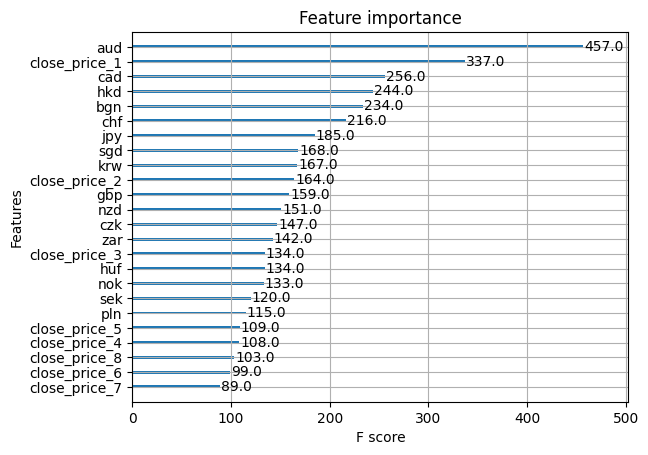

In [102]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=24)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path, bbox_inches='tight')
plt.show()

## Save model

In [103]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [104]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [105]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [106]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="gold_prices_xgboost_model", 
    version=1,
    metrics=res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="gold prices predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/494573 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/55362 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48883 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/341 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2331 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1163416/models/gold_prices_xgboost_model/1


Model(name: 'gold_prices_xgboost_model', version: 1)